#### CSC180 Project 3

#### Xiong Moua Student_id: 220278332
#### William Moosakhanian Student_id: 302537495

#### ** ****IMPORTS**** **

In [1]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
from tensorflow.keras.layers import LSTM
import cv2
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
import pandas as pd
import json
import numpy as np
import sklearn.feature_extraction.text as sk_text
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import os
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
warnings.filterwarnings('ignore')
start = time.time()

In [2]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

#### **Basic MODEL** 

In [3]:
filename_read = os.path.join("Houses_Dataset/HousesInfo.txt")

In [4]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]

In [5]:
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [6]:
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [7]:
df.shape

(535, 5)

In [8]:
num = []
for i in range(df.shape[0]):
    num.append(i+1)
    # print(i+1)

In [9]:
df['num'] = num

In [10]:
df.head()
#df.to_csv('filtered.csv', sep=',', index=False)

,Bedrooms,Bathrooms,area,zipcode,price,num
0,4,4.0,4053,85255,869500,1
1,4,3.0,3343,36372,865200,2
2,3,4.0,3923,85266,889000,3
3,5,5.0,4022,85262,910000,4
4,3,4.0,4116,85266,971226,5


#### **Removing the Outliers from the Dataset**

In [11]:
filtered_df = df[(df['price'] > 100000) & (df['price'] < 900000)]


In [12]:
filtered_df.head()


,Bedrooms,Bathrooms,area,zipcode,price,num
0,4,4.0,4053,85255,869500,1
1,4,3.0,3343,36372,865200,2
2,3,4.0,3923,85266,889000,3
6,3,4.0,2544,85262,799000,7
10,5,5.0,4829,85266,519200,11


In [13]:
# filtered_df.to_csv('filtered.csv', sep=',', index=False)

In [14]:
filtered_num = filtered_df['num'].to_list()
print(filtered_num)

[1, 2, 3, 7, 11, 13, 14, 15, 16, 17, 18, 23, 28, 31, 33, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 92, 94, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 114, 115, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 132, 135, 136, 138, 139, 140, 141, 142, 143, 145, 146, 148, 152, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 188, 189, 190, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 205, 206, 207, 209, 211, 212, 213, 214, 218, 222, 223, 226, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 259, 260, 263, 264, 265, 266, 268, 270, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 287, 288, 291, 292, 294, 295

In [15]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("Houses_dataset/Houses dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            if number in filtered_num:
                # print(number)
                new_images.append(path)

In [16]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [17]:
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            if number in filtered_num:
                bedroom_images.append(path) 
                # print(number)

In [18]:
img['bedroom_img']=bedroom_images

In [19]:
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            if number in filtered_num:
                frontal_images.append(path)
                # print(number)

In [20]:
img['frontal_img']=frontal_images

In [21]:
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            if number in filtered_num:
                kitchen_images.append(path)

In [22]:
img['kitchen_img']=kitchen_images

In [23]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,Houses_dataset/Houses dataset/1_bathroom.jpg,Houses_Dataset/Houses dataset/1_bedroom.jpg,Houses_Dataset/Houses dataset/1_frontal.jpg,Houses_Dataset/Houses dataset/1_kitchen.jpg
1,Houses_dataset/Houses dataset/2_bathroom.jpg,Houses_Dataset/Houses dataset/2_bedroom.jpg,Houses_Dataset/Houses dataset/2_frontal.jpg,Houses_Dataset/Houses dataset/2_kitchen.jpg
2,Houses_dataset/Houses dataset/3_bathroom.jpg,Houses_Dataset/Houses dataset/3_bedroom.jpg,Houses_Dataset/Houses dataset/3_frontal.jpg,Houses_Dataset/Houses dataset/3_kitchen.jpg
3,Houses_dataset/Houses dataset/7_bathroom.jpg,Houses_Dataset/Houses dataset/7_bedroom.jpg,Houses_Dataset/Houses dataset/7_frontal.jpg,Houses_Dataset/Houses dataset/7_kitchen.jpg
4,Houses_dataset/Houses dataset/11_bathroom.jpg,Houses_Dataset/Houses dataset/11_bedroom.jpg,Houses_Dataset/Houses dataset/11_frontal.jpg,Houses_Dataset/Houses dataset/11_kitchen.jpg


In [24]:
img.shape

(405, 4)

In [25]:
images_output=[]
for row_index,row in img.iterrows():
    inputImages=[]
    outputImage = np.zeros((128, 128, 3), dtype="uint8")
    image_temp1 = cv2.imread(row.bathroom_img)
    image1 = cv2.resize(image_temp1, (64 , 64))

    image_temp2 = cv2.imread(row.bedroom_img)
    image2 = cv2.resize(image_temp2, (64 , 64))

    image_temp3 = cv2.imread(row.frontal_img)
    image3 = cv2.resize(image_temp3, (64 , 64))

    image_temp4 = cv2.imread(row.kitchen_img)
    image4 = cv2.resize(image_temp4, (64 , 64))

    inputImages.append(image1)
    inputImages.append(image2)
    inputImages.append(image3)
    inputImages.append(image4)

    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]
            
        
    images_output.append(outputImage) 

In [26]:
from matplotlib import pyplot as plt

# for i in images_output:
#      plt.figure(figsize=(8,8))
#      plt.imshow(i, interpolation='nearest')
#      plt.show()

In [27]:
img_arr=np.asarray(images_output)

In [28]:
img_arr.shape

(405, 128, 128, 3)

In [29]:
filtered_df.head()

,Bedrooms,Bathrooms,area,zipcode,price,num
0,4,4.0,4053,85255,869500,1
1,4,3.0,3343,36372,865200,2
2,3,4.0,3923,85266,889000,3
6,3,4.0,2544,85262,799000,7
10,5,5.0,4829,85266,519200,11


#### **One-hot encoding and normalizing the features**

In [30]:
#one-hot encoding
#encode_text_dummy(filtered_df, 'area')
encode_text_dummy(filtered_df, 'zipcode')
encode_text_dummy(filtered_df, 'Bedrooms')
encode_text_dummy(filtered_df, 'Bathrooms')
#normalize
encode_numeric_zscore(filtered_df, 'area')

In [31]:
filtered_df.head()

,area,price,num,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.539241,869500,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.916083,865200,2,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.425142,889000,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0.214810,799000,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,2.220327,519200,11,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [32]:
filtered_df = filtered_df.drop('num', axis=1)

In [33]:
filtered_df.head()

,area,price,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.539241,869500,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.916083,865200,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.425142,889000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0.214810,799000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,2.220327,519200,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
filtered_df.shape

(405, 62)

In [35]:
# filtered_df.to_csv('encoded.csv', sep=',', index=False)

In [36]:
num_data = filtered_df.to_numpy()

In [37]:
num_data.shape

(405, 62)

In [38]:
y = filtered_df['price']

In [39]:
y.shape

(405,)

In [40]:
filtered_df = filtered_df.drop('price', axis=1)

In [41]:
filtered_df.head()

,area,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.539241,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.916083,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.425142,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,0.214810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,2.220327,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### **Spliting the Data between training and training**

In [42]:
cnn_train,cnn_test, num_cat_train, num_cat_test,y_train,y_test = train_test_split(img_arr, filtered_df,y, test_size=0.25, random_state=100)

In [43]:
print(cnn_train.shape)
print(cnn_test.shape)
print(num_cat_train.shape)
print(num_cat_test.shape)
print(y_train.shape)
print(y_test.shape)

(303, 128, 128, 3)
(102, 128, 128, 3)
(303, 61)
(102, 61)
(303,)
(102,)


#### **First Model with dataset, Early Stopping and Weights**

In [44]:
checkpointer = ModelCheckpoint(filepath='dnn/mergemodel.hdf5', verbose=0, save_best_only=True)
for i in range(5):
    print("Round ", i+1, " of training:")
    
    image_cnn = Input(shape=(128,128,3))
    image_conv = Conv2D(32, kernel_size=(4, 4), activation='relu')(image_cnn)
    image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
    image_conv2 = Conv2D(64, kernel_size=(4, 4), activation='relu')(image_pool)
    image_pool2 = MaxPooling2D(pool_size=(2, 2))(image_conv2)
    flat1 = Flatten()(image_pool2)

    num_cat = Input(shape=(num_cat_train.shape[1],))
    num_cat_hidden1 = Dense(128, activation='relu')(num_cat)
    num_cat_hidden2 = Dense(64, activation='relu')(num_cat_hidden1)
    num_cat_hidden3 = Dense(32, activation='relu')(num_cat_hidden2)
    num_cat_hidden4 = Dense(16, activation='relu')(num_cat_hidden3)
    
    merge = concatenate([flat1, num_cat_hidden4])

    hidden1 = Dense(10, activation='relu')(merge)
    hidden2 = Dense(10, activation='relu')(hidden1)
    output = Dense(1, activation='linear')(hidden2)

    rate = 0.001
    opt = Adam(learning_rate=rate)
    
    model = Model(inputs=[image_cnn, num_cat], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    history = model.fit(x=[cnn_train, num_cat_train], y=y_train, batch_size=32, epochs=1000, validation_split=0.2, callbacks = [monitor, checkpointer], verbose = 1)


Round  1  of training:
Epoch 1/1000
8/8 [==============================] - 5s 66ms/step - loss: 268240814080.0000 - mean_absolute_error: 471658.8438 - val_loss: 251474526208.0000 - val_mean_absolute_error: 452452.9062
Epoch 2/1000
8/8 [==============================] - 0s 24ms/step - loss: 172903677952.0000 - mean_absolute_error: 352401.1875 - val_loss: 58479161344.0000 - val_mean_absolute_error: 204592.8750
Epoch 3/1000
8/8 [==============================] - 0s 24ms/step - loss: 69757960192.0000 - mean_absolute_error: 217248.7969 - val_loss: 49103826944.0000 - val_mean_absolute_error: 176306.5938
Epoch 4/1000
8/8 [==============================] - 0s 17ms/step - loss: 52125065216.0000 - mean_absolute_error: 187946.4688 - val_loss: 68014465024.0000 - val_mean_absolute_error: 219847.9844
Epoch 5/1000
8/8 [==============================] - 0s 24ms/step - loss: 55169855488.0000 - mean_absolute_error: 194826.9062 - val_loss: 44758265856.0000 - val_mean_absolute_error: 170748.4844
Epoch 6/1

Epoch 86/1000
8/8 [==============================] - 0s 19ms/step - loss: 7658717184.0000 - mean_absolute_error: 66907.3281 - val_loss: 23138930688.0000 - val_mean_absolute_error: 107771.0469
Epoch 87/1000
8/8 [==============================] - 0s 26ms/step - loss: 6883374080.0000 - mean_absolute_error: 61737.6758 - val_loss: 20336533504.0000 - val_mean_absolute_error: 103409.2891
Epoch 88/1000
8/8 [==============================] - 0s 18ms/step - loss: 6408159744.0000 - mean_absolute_error: 58518.4141 - val_loss: 20585854976.0000 - val_mean_absolute_error: 102891.8047
Epoch 89/1000
8/8 [==============================] - 0s 18ms/step - loss: 6258321408.0000 - mean_absolute_error: 57439.9492 - val_loss: 21597835264.0000 - val_mean_absolute_error: 104640.2891
Epoch 90/1000
8/8 [==============================] - 0s 19ms/step - loss: 6098348032.0000 - mean_absolute_error: 56423.3008 - val_loss: 20584665088.0000 - val_mean_absolute_error: 103074.1406
Epoch 91/1000
8/8 [=====================

8/8 [==============================] - 0s 19ms/step - loss: 25787553792.0000 - mean_absolute_error: 128943.7422 - val_loss: 27556427776.0000 - val_mean_absolute_error: 136044.2188
Epoch 37/1000
8/8 [==============================] - 0s 18ms/step - loss: 24227246080.0000 - mean_absolute_error: 123750.7109 - val_loss: 26764867584.0000 - val_mean_absolute_error: 134328.0781
Epoch 38/1000
8/8 [==============================] - 0s 19ms/step - loss: 23196014592.0000 - mean_absolute_error: 119441.5703 - val_loss: 26044590080.0000 - val_mean_absolute_error: 129807.1328
Epoch 39/1000
8/8 [==============================] - 0s 18ms/step - loss: 22110615552.0000 - mean_absolute_error: 118684.4531 - val_loss: 24958844928.0000 - val_mean_absolute_error: 126910.2969
Epoch 40/1000
8/8 [==============================] - 0s 18ms/step - loss: 20948529152.0000 - mean_absolute_error: 113571.2422 - val_loss: 24309323776.0000 - val_mean_absolute_error: 123490.5078
Epoch 41/1000
8/8 [=========================

8/8 [==============================] - 0s 19ms/step - loss: 39174701056.0000 - mean_absolute_error: 160882.5312 - val_loss: 41922990080.0000 - val_mean_absolute_error: 171256.0938
Epoch 30/1000
8/8 [==============================] - 0s 19ms/step - loss: 40181088256.0000 - mean_absolute_error: 162055.2031 - val_loss: 38591696896.0000 - val_mean_absolute_error: 159374.7500
Epoch 31/1000
8/8 [==============================] - 0s 19ms/step - loss: 38606721024.0000 - mean_absolute_error: 158744.0625 - val_loss: 37473775616.0000 - val_mean_absolute_error: 158789.7500
Epoch 32/1000
8/8 [==============================] - 0s 18ms/step - loss: 35591602176.0000 - mean_absolute_error: 152715.7188 - val_loss: 36284375040.0000 - val_mean_absolute_error: 156793.9062
Epoch 33/1000
8/8 [==============================] - 0s 18ms/step - loss: 35056734208.0000 - mean_absolute_error: 150467.1250 - val_loss: 34747867136.0000 - val_mean_absolute_error: 152387.0781
Epoch 34/1000
8/8 [=========================

8/8 [==============================] - 0s 19ms/step - loss: 44131635200.0000 - mean_absolute_error: 172204.0312 - val_loss: 44464889856.0000 - val_mean_absolute_error: 172397.7656
Epoch 16/1000
8/8 [==============================] - 0s 18ms/step - loss: 43848417280.0000 - mean_absolute_error: 170472.1875 - val_loss: 44420034560.0000 - val_mean_absolute_error: 172383.4688
Epoch 17/1000
8/8 [==============================] - 0s 18ms/step - loss: 44815392768.0000 - mean_absolute_error: 174431.8281 - val_loss: 44074442752.0000 - val_mean_absolute_error: 170792.0312
Epoch 18/1000
8/8 [==============================] - 0s 19ms/step - loss: 45786849280.0000 - mean_absolute_error: 173964.4844 - val_loss: 45397188608.0000 - val_mean_absolute_error: 176729.0469
Epoch 19/1000
8/8 [==============================] - 0s 18ms/step - loss: 47064211456.0000 - mean_absolute_error: 180811.8906 - val_loss: 44724379648.0000 - val_mean_absolute_error: 174500.3906
Epoch 20/1000
8/8 [=========================

Epoch 100/1000
8/8 [==============================] - 0s 19ms/step - loss: 5442624512.0000 - mean_absolute_error: 53858.1133 - val_loss: 20116393984.0000 - val_mean_absolute_error: 102533.3125
Epoch 101/1000
8/8 [==============================] - 0s 25ms/step - loss: 5495512064.0000 - mean_absolute_error: 53254.8906 - val_loss: 18823954432.0000 - val_mean_absolute_error: 101758.6094
Epoch 102/1000
8/8 [==============================] - 0s 18ms/step - loss: 5434071040.0000 - mean_absolute_error: 53595.8086 - val_loss: 19738656768.0000 - val_mean_absolute_error: 101904.1484
Epoch 103/1000
8/8 [==============================] - 0s 18ms/step - loss: 5371368960.0000 - mean_absolute_error: 53651.7617 - val_loss: 18978236416.0000 - val_mean_absolute_error: 100899.3750
Epoch 104/1000
8/8 [==============================] - 0s 19ms/step - loss: 5334449152.0000 - mean_absolute_error: 52827.5117 - val_loss: 18886731776.0000 - val_mean_absolute_error: 100870.7812
Epoch 105/1000
8/8 [===============

8/8 [==============================] - 0s 18ms/step - loss: 25688387584.0000 - mean_absolute_error: 130671.1953 - val_loss: 26941732864.0000 - val_mean_absolute_error: 134878.2188
Epoch 42/1000
8/8 [==============================] - 0s 18ms/step - loss: 25926082560.0000 - mean_absolute_error: 124357.5391 - val_loss: 26131132416.0000 - val_mean_absolute_error: 133312.7188
Epoch 43/1000
8/8 [==============================] - 0s 18ms/step - loss: 24293054464.0000 - mean_absolute_error: 127440.4766 - val_loss: 25292279808.0000 - val_mean_absolute_error: 129414.3281
Epoch 44/1000
8/8 [==============================] - 0s 19ms/step - loss: 22243100672.0000 - mean_absolute_error: 117877.9219 - val_loss: 24627363840.0000 - val_mean_absolute_error: 127611.0625
Epoch 45/1000
8/8 [==============================] - 0s 18ms/step - loss: 21302284288.0000 - mean_absolute_error: 116351.2969 - val_loss: 24109514752.0000 - val_mean_absolute_error: 124830.5703
Epoch 46/1000
8/8 [=========================

In [45]:
predictions = model.predict([cnn_test, num_cat_test])
scores = np.sqrt(metrics.mean_squared_error(predictions,y_test))
print("Final score (RMSE): {}".format(scores))

4/4 [==============================] - 0s 14ms/step
Final score (RMSE): 131075.07804388198


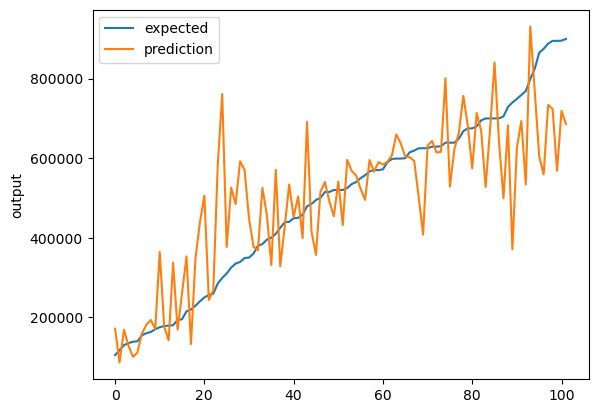

In [46]:
chart_regression(predictions.flatten(),y_test, sort= True)

#### **Additional Feature #1 Model with dropout layers**

In [47]:
checkpointer = ModelCheckpoint(filepath='dnn/mergemodel_add_dropout.hdf5', verbose=0, save_best_only=True)
for i in range(5):
    print("Round ", i+1, " of training:")
    
    image_cnn = Input(shape=(128,128,3))
    image_conv = Conv2D(32, kernel_size=(4, 4), activation='relu')(image_cnn)
    image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
    image_drop1 = Dropout(0.25)(image_pool)
    image_conv2 = Conv2D(64, kernel_size=(4, 4), activation='relu')(image_drop1)
    image_pool2 = MaxPooling2D(pool_size=(2, 2))(image_conv2)
    image_drop2 = Dropout(0.125)(image_pool2)
    flat1 = Flatten()(image_drop2)

    num_cat = Input(shape=(num_cat_train.shape[1],))
    num_cat_hidden1 = Dense(512, activation='relu')(num_cat)
    num_cat_hidden2 = Dense(256, activation='relu')(num_cat_hidden1)
    num_cat_hidden3 = Dense(256, activation='relu')(num_cat_hidden2)
    num_cat_hidden4 = Dense(256, activation='relu')(num_cat_hidden3)
    num_cat_hidden5 = Dense(128, activation='relu')(num_cat_hidden4)
    
    merge = concatenate([flat1, num_cat_hidden5])

    hidden1 = Dense(128, activation='relu')(merge)
    hidden2 = Dense(64, activation='relu')(hidden1)
    hidden3 = Dense(32, activation='relu')(hidden2)
    hidden4 = Dense(16, activation='relu')(hidden3)
    output = Dense(1, activation='linear')(hidden4)

    rate = 0.01
    opt = Adam(learning_rate=rate)
    
    model = Model(inputs=[image_cnn, num_cat], outputs=output)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    history = model.fit(x=[cnn_train, num_cat_train], y=y_train, batch_size=32, epochs=1000, validation_split=0.2, callbacks = [monitor, checkpointer], verbose = 1)


Round  1  of training:
Epoch 1/1000
8/8 [==============================] - 1s 81ms/step - loss: 1078114975744.0000 - mean_absolute_error: 683149.6875 - val_loss: 292742103040.0000 - val_mean_absolute_error: 495472.8438
Epoch 2/1000
8/8 [==============================] - 0s 23ms/step - loss: 276292173824.0000 - mean_absolute_error: 480291.4688 - val_loss: 292750524416.0000 - val_mean_absolute_error: 495483.1562
Epoch 3/1000
8/8 [==============================] - 0s 43ms/step - loss: 276171587584.0000 - mean_absolute_error: 480171.8438 - val_loss: 290668445696.0000 - val_mean_absolute_error: 493563.1875
Epoch 4/1000
8/8 [==============================] - 0s 44ms/step - loss: 244450705408.0000 - mean_absolute_error: 443157.7500 - val_loss: 57487396864.0000 - val_mean_absolute_error: 176235.3125
Epoch 5/1000
8/8 [==============================] - 0s 45ms/step - loss: 55403163648.0000 - mean_absolute_error: 172998.0781 - val_loss: 38430248960.0000 - val_mean_absolute_error: 153933.7656
Epoc

8/8 [==============================] - 0s 20ms/step - loss: 4825779712.0000 - mean_absolute_error: 49880.8242 - val_loss: 16891907072.0000 - val_mean_absolute_error: 96785.9375
Epoch 22/1000
8/8 [==============================] - 0s 19ms/step - loss: 4772381696.0000 - mean_absolute_error: 48820.3086 - val_loss: 18354167808.0000 - val_mean_absolute_error: 107863.5703
Epoch 23/1000
8/8 [==============================] - 0s 20ms/step - loss: 5043763712.0000 - mean_absolute_error: 51106.0547 - val_loss: 17551802368.0000 - val_mean_absolute_error: 94143.5938
Epoch 24/1000
8/8 [==============================] - 0s 20ms/step - loss: 4166226432.0000 - mean_absolute_error: 43720.5820 - val_loss: 17968728064.0000 - val_mean_absolute_error: 96069.3594
Epoch 25/1000
8/8 [==============================] - 0s 20ms/step - loss: 5224285696.0000 - mean_absolute_error: 51272.5703 - val_loss: 17944983552.0000 - val_mean_absolute_error: 96184.5156
Epoch 26/1000
8/8 [==============================] - 0s 41

8/8 [==============================] - 0s 20ms/step - loss: 4959345152.0000 - mean_absolute_error: 52229.8320 - val_loss: 15960169472.0000 - val_mean_absolute_error: 93062.8828
Epoch 20/1000
8/8 [==============================] - 0s 20ms/step - loss: 4891689472.0000 - mean_absolute_error: 51335.2031 - val_loss: 16124162048.0000 - val_mean_absolute_error: 91769.3594
Epoch 21/1000
8/8 [==============================] - 0s 40ms/step - loss: 5320271872.0000 - mean_absolute_error: 55206.6719 - val_loss: 15228562432.0000 - val_mean_absolute_error: 89375.3750
Epoch 22/1000
8/8 [==============================] - 0s 20ms/step - loss: 5367923200.0000 - mean_absolute_error: 54052.5078 - val_loss: 15523968000.0000 - val_mean_absolute_error: 93058.2266
Epoch 23/1000
8/8 [==============================] - 0s 21ms/step - loss: 4205606912.0000 - mean_absolute_error: 46128.9961 - val_loss: 16680835072.0000 - val_mean_absolute_error: 92077.7422
Epoch 24/1000
8/8 [==============================] - 0s 40m

In [48]:
predictions = model.predict([cnn_test, num_cat_test])
scores = np.sqrt(metrics.mean_squared_error(predictions,y_test))
print("Final score (RMSE): {}".format(scores))

4/4 [==============================] - 0s 8ms/step
Final score (RMSE): 117604.06080648597


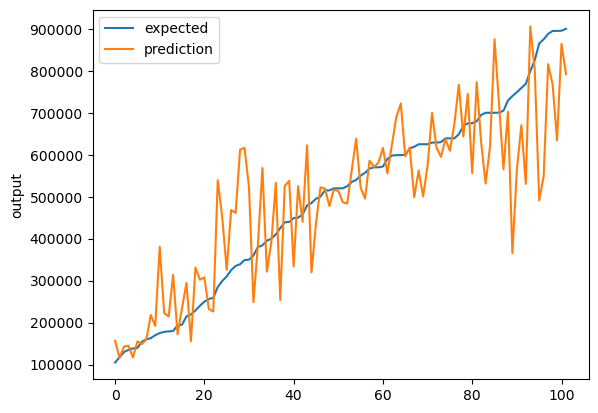

In [49]:
chart_regression(predictions.flatten(),y_test, sort= True)

#### **Additional Feature #2 Removing Zipcodes with less house**
#### **Selected different range of house prices**

In [50]:
min_price = 0
max_price = 800000
min_zip = 90602
max_zip = 94002

add_df = df[(df['price'] > min_price) & (df['price'] < max_price)]
add_df = add_df[(df['zipcode'] > min_zip) & (add_df['zipcode'] < max_zip)]

In [51]:
add_df.head()

,Bedrooms,Bathrooms,area,zipcode,price,num
30,5,3.0,2520,93446,789000,31
32,3,2.0,1802,93446,365000,33
39,3,3.0,2146,93446,455000,40
80,4,2.5,2464,91901,599000,81
81,2,2.0,1845,91901,529800,82


In [52]:
#add_df.to_csv('outlier.csv', sep=',', index=False)

In [53]:
filtered_num_add = add_df['num'].to_list()

new_images_add=[]

for number in range(1, 536):
    for path in glob.glob("Houses_dataset/Houses dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            if number in filtered_num_add:
                # print(number)
                new_images_add.append(path)

img_add = pd.DataFrame(new_images_add,columns = ['bathroom_img'])

bedroom_images_add = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            if number in filtered_num_add:
                bedroom_images_add.append(path) 
                # print(number)
                
img_add['bedroom_img']=bedroom_images_add

frontal_images_add = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            if number in filtered_num_add:
                frontal_images_add.append(path)
                # print(number)
                
img_add['frontal_img']=frontal_images_add

kitchen_images_add = []
for number in range(1, 536):
    for path in glob.glob("Houses_Dataset/Houses dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            if number in filtered_num_add:
                kitchen_images_add.append(path)
                
img_add['kitchen_img']=kitchen_images_add

img_add.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,Houses_dataset/Houses dataset/31_bathroom.jpg,Houses_Dataset/Houses dataset/31_bedroom.jpg,Houses_Dataset/Houses dataset/31_frontal.jpg,Houses_Dataset/Houses dataset/31_kitchen.jpg
1,Houses_dataset/Houses dataset/33_bathroom.jpg,Houses_Dataset/Houses dataset/33_bedroom.jpg,Houses_Dataset/Houses dataset/33_frontal.jpg,Houses_Dataset/Houses dataset/33_kitchen.jpg
2,Houses_dataset/Houses dataset/40_bathroom.jpg,Houses_Dataset/Houses dataset/40_bedroom.jpg,Houses_Dataset/Houses dataset/40_frontal.jpg,Houses_Dataset/Houses dataset/40_kitchen.jpg
3,Houses_dataset/Houses dataset/81_bathroom.jpg,Houses_Dataset/Houses dataset/81_bedroom.jpg,Houses_Dataset/Houses dataset/81_frontal.jpg,Houses_Dataset/Houses dataset/81_kitchen.jpg
4,Houses_dataset/Houses dataset/82_bathroom.jpg,Houses_Dataset/Houses dataset/82_bedroom.jpg,Houses_Dataset/Houses dataset/82_frontal.jpg,Houses_Dataset/Houses dataset/82_kitchen.jpg


In [54]:
images_output_add=[]

for row_index,row in img_add.iterrows():
    inputImages=[]
    outputImage = np.zeros((128, 128, 3), dtype="uint8")
    image_temp1 = cv2.imread(row.bathroom_img)
    image1 = cv2.resize(image_temp1, (64 , 64))
            
    image_temp2 = cv2.imread(row.bedroom_img)
    image2 = cv2.resize(image_temp2, (64 , 64))
        
    image_temp3 = cv2.imread(row.frontal_img)
    image3 = cv2.resize(image_temp3, (64 , 64))
            
    image_temp4 = cv2.imread(row.kitchen_img)
    image4 = cv2.resize(image_temp4, (64 , 64))
              
    inputImages.append(image1)
    inputImages.append(image2)
    inputImages.append(image3)
    inputImages.append(image4)
            
    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]
            
    images_output_add.append(outputImage) 
    
img_arr_add=np.asarray(images_output_add)

encode_text_dummy(add_df, 'zipcode')
encode_text_dummy(add_df, 'Bedrooms')
encode_text_dummy(add_df, 'Bathrooms')
#normalize
encode_numeric_zscore(add_df, 'area')

filtered_df_add = add_df.drop('num', axis=1)

In [55]:
filtered_df_add.head()
y_add = filtered_df_add['price']
filtered_df_add = filtered_df_add.drop('price', axis=1)

cnn_train_add, cnn_test_add, num_cat_train_add, num_cat_test_add, y_train_add, y_test_add = train_test_split(img_arr_add, filtered_df_add, y_add, test_size=0.25, random_state=100)

In [56]:
# print(cnn_train_add.shape)
# print(cnn_test_add.shape)
# print(num_cat_train_add.shape)
# print(num_cat_test_add.shape)
# print(y_train_add.shape)
# print(y_test_add.shape)

print(img_arr_add.shape)
print(filtered_df_add.shape)
print(y_add.shape)

(317, 128, 128, 3)
(317, 37)
(317,)


In [57]:
checkpointer = ModelCheckpoint(filepath='dnn/mergemodel_add_outlier.hdf5', verbose=0, save_best_only=True)
for i in range(5):
    print("Round ", i+1, " of training:")
    
    image_cnn = Input(shape=(128,128,3))
    image_conv = Conv2D(32, kernel_size=(4, 4), activation='relu')(image_cnn)
    image_pool = MaxPooling2D(pool_size=(2, 2))(image_conv)
    image_drop2 = Dropout(0.25)(image_pool)
    image_conv2 = Conv2D(64, kernel_size=(4, 4), activation='relu')(image_drop2)
    image_pool2 = MaxPooling2D(pool_size=(2, 2))(image_conv2)
    flat1 = Flatten()(image_pool2)

    num_cat = Input(shape=(num_cat_train_add.shape[1],))
    num_cat_hidden1 = Dense(512, activation='relu')(num_cat)
    num_cat_hidden2 = Dense(256, activation='relu')(num_cat_hidden1)
    num_cat_hidden3 = Dense(256, activation='relu')(num_cat_hidden2)
    num_cat_hidden4 = Dense(256, activation='relu')(num_cat_hidden3)
    num_cat_hidden5 = Dense(128, activation='relu')(num_cat_hidden4)
    
    merge = concatenate([flat1, num_cat_hidden5])

    hidden1 = Dense(128, activation='relu')(merge)
    hidden2 = Dense(64, activation='relu')(hidden1)
    hidden3 = Dense(32, activation='relu')(hidden2)
    hidden4 = Dense(16, activation='relu')(hidden3)
    output = Dense(1, activation='linear')(hidden4)

    rate = 0.001
    opt = Adam(learning_rate=rate)
    
    model_add = Model(inputs=[image_cnn, num_cat], outputs=output)
    model_add.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=1, mode='auto')
    history = model_add.fit(x=[cnn_train_add, num_cat_train_add], y=y_train_add, batch_size=32, epochs=1000, validation_split=0.2, callbacks = [monitor, checkpointer], verbose = 1)


Round  1  of training:
Epoch 1/1000
6/6 [==============================] - 1s 128ms/step - loss: 202813636608.0000 - mean_absolute_error: 391119.2500 - val_loss: 150980804608.0000 - val_mean_absolute_error: 318956.7812
Epoch 2/1000
6/6 [==============================] - 0s 50ms/step - loss: 81501110272.0000 - mean_absolute_error: 231546.6406 - val_loss: 94159478784.0000 - val_mean_absolute_error: 244083.6406
Epoch 3/1000
6/6 [==============================] - 0s 49ms/step - loss: 65854263296.0000 - mean_absolute_error: 207465.9688 - val_loss: 67634921472.0000 - val_mean_absolute_error: 227670.4531
Epoch 4/1000
6/6 [==============================] - 0s 50ms/step - loss: 65746497536.0000 - mean_absolute_error: 222795.4844 - val_loss: 64010158080.0000 - val_mean_absolute_error: 222491.0469
Epoch 5/1000
6/6 [==============================] - 0s 51ms/step - loss: 52364918784.0000 - mean_absolute_error: 197980.1250 - val_loss: 58359427072.0000 - val_mean_absolute_error: 203086.4219
Epoch 6/1

Epoch 44/1000
6/6 [==============================] - 0s 50ms/step - loss: 5072001536.0000 - mean_absolute_error: 50394.8711 - val_loss: 8690336768.0000 - val_mean_absolute_error: 69713.2969
Epoch 45/1000
6/6 [==============================] - 0s 50ms/step - loss: 4822688768.0000 - mean_absolute_error: 48770.2070 - val_loss: 8629046272.0000 - val_mean_absolute_error: 69475.9609
Epoch 46/1000
6/6 [==============================] - 0s 50ms/step - loss: 4687979520.0000 - mean_absolute_error: 47723.1680 - val_loss: 8568915968.0000 - val_mean_absolute_error: 69651.4453
Epoch 47/1000
6/6 [==============================] - 0s 49ms/step - loss: 4623279616.0000 - mean_absolute_error: 47447.3398 - val_loss: 8547835904.0000 - val_mean_absolute_error: 69687.8594
Epoch 48/1000
6/6 [==============================] - 0s 22ms/step - loss: 4673839616.0000 - mean_absolute_error: 48671.7031 - val_loss: 8562062848.0000 - val_mean_absolute_error: 70099.7422
Epoch 49/1000
6/6 [==============================]

Epoch 15/1000
6/6 [==============================] - 0s 23ms/step - loss: 10910874624.0000 - mean_absolute_error: 83209.5156 - val_loss: 12700072960.0000 - val_mean_absolute_error: 79994.6016
Epoch 16/1000
6/6 [==============================] - 0s 23ms/step - loss: 8884262912.0000 - mean_absolute_error: 68795.4531 - val_loss: 12478868480.0000 - val_mean_absolute_error: 79674.2891
Epoch 17/1000
6/6 [==============================] - 0s 23ms/step - loss: 8213302784.0000 - mean_absolute_error: 68543.9062 - val_loss: 12360848384.0000 - val_mean_absolute_error: 81345.8125
Epoch 18/1000
6/6 [==============================] - 0s 25ms/step - loss: 7602301440.0000 - mean_absolute_error: 63609.1836 - val_loss: 12201219072.0000 - val_mean_absolute_error: 78546.7578
Epoch 19/1000
6/6 [==============================] - 0s 24ms/step - loss: 7348905472.0000 - mean_absolute_error: 62234.4141 - val_loss: 11847977984.0000 - val_mean_absolute_error: 77638.1797
Epoch 20/1000
6/6 [=========================

6/6 [==============================] - 0s 24ms/step - loss: 4124789248.0000 - mean_absolute_error: 43705.7148 - val_loss: 8207307264.0000 - val_mean_absolute_error: 69989.6641
Epoch 59/1000
6/6 [==============================] - 0s 50ms/step - loss: 4117329408.0000 - mean_absolute_error: 43764.6914 - val_loss: 8174332416.0000 - val_mean_absolute_error: 70099.7031
Epoch 60/1000
6/6 [==============================] - 0s 49ms/step - loss: 4105824768.0000 - mean_absolute_error: 43706.4297 - val_loss: 8173952512.0000 - val_mean_absolute_error: 69737.8516
Epoch 61/1000
6/6 [==============================] - 0s 23ms/step - loss: 4216480768.0000 - mean_absolute_error: 44966.5625 - val_loss: 8250351616.0000 - val_mean_absolute_error: 71105.9062
Epoch 62/1000
6/6 [==============================] - 0s 23ms/step - loss: 4135021568.0000 - mean_absolute_error: 44275.8242 - val_loss: 8187088896.0000 - val_mean_absolute_error: 69970.7891
Epoch 63/1000
6/6 [==============================] - 0s 23ms/ste

Epoch 8/1000
6/6 [==============================] - 0s 23ms/step - loss: 44080676864.0000 - mean_absolute_error: 183737.6719 - val_loss: 49738919936.0000 - val_mean_absolute_error: 195944.3750
Epoch 9/1000
6/6 [==============================] - 0s 24ms/step - loss: 42190630912.0000 - mean_absolute_error: 177736.2500 - val_loss: 46823092224.0000 - val_mean_absolute_error: 189672.0156
Epoch 10/1000
6/6 [==============================] - 0s 23ms/step - loss: 36918136832.0000 - mean_absolute_error: 170283.5000 - val_loss: 35757518848.0000 - val_mean_absolute_error: 162593.2031
Epoch 11/1000
6/6 [==============================] - 0s 24ms/step - loss: 26010810368.0000 - mean_absolute_error: 136047.7812 - val_loss: 22613596160.0000 - val_mean_absolute_error: 118878.9922
Epoch 12/1000
6/6 [==============================] - 0s 24ms/step - loss: 17256288256.0000 - mean_absolute_error: 110395.5156 - val_loss: 16828269568.0000 - val_mean_absolute_error: 94310.5078
Epoch 13/1000
6/6 [==============

Epoch 51/1000
6/6 [==============================] - 0s 24ms/step - loss: 4138316544.0000 - mean_absolute_error: 44901.3008 - val_loss: 8549751296.0000 - val_mean_absolute_error: 70438.9844
Epoch 52/1000
6/6 [==============================] - 0s 23ms/step - loss: 4672967680.0000 - mean_absolute_error: 48523.9688 - val_loss: 8943635456.0000 - val_mean_absolute_error: 72608.2500
Epoch 53/1000
6/6 [==============================] - 0s 23ms/step - loss: 3942944256.0000 - mean_absolute_error: 44209.6602 - val_loss: 8579512832.0000 - val_mean_absolute_error: 70278.7109
Epoch 54/1000
6/6 [==============================] - 0s 23ms/step - loss: 3732406528.0000 - mean_absolute_error: 42371.9141 - val_loss: 8529823744.0000 - val_mean_absolute_error: 71245.4141
Epoch 55/1000
6/6 [==============================] - 0s 24ms/step - loss: 3451973632.0000 - mean_absolute_error: 40376.5234 - val_loss: 8496734720.0000 - val_mean_absolute_error: 69991.1328
Epoch 56/1000
6/6 [==============================]

6/6 [==============================] - 0s 23ms/step - loss: 4866654208.0000 - mean_absolute_error: 50326.9141 - val_loss: 8775271424.0000 - val_mean_absolute_error: 70632.2109
Epoch 70/1000
6/6 [==============================] - 0s 23ms/step - loss: 4225355008.0000 - mean_absolute_error: 45787.0312 - val_loss: 9115896832.0000 - val_mean_absolute_error: 71225.1094
Epoch 71/1000
6/6 [==============================] - 0s 23ms/step - loss: 4456432640.0000 - mean_absolute_error: 47948.5039 - val_loss: 8950030336.0000 - val_mean_absolute_error: 71776.9453
Epoch 72/1000
6/6 [==============================] - 0s 24ms/step - loss: 4325752320.0000 - mean_absolute_error: 45943.4336 - val_loss: 9290345472.0000 - val_mean_absolute_error: 71800.7500
Epoch 73/1000
6/6 [==============================] - 0s 24ms/step - loss: 4158613248.0000 - mean_absolute_error: 45670.8633 - val_loss: 8877248512.0000 - val_mean_absolute_error: 71684.3125
Epoch 74/1000
6/6 [==============================] - 0s 23ms/ste

In [58]:
predictions_add = model_add.predict([cnn_test_add, num_cat_test_add])
scores_add = np.sqrt(metrics.mean_squared_error(predictions_add,y_test_add))
print("Final score (RMSE): {}".format(scores_add))

3/3 [==============================] - 0s 5ms/step
Final score (RMSE): 97646.37159324558


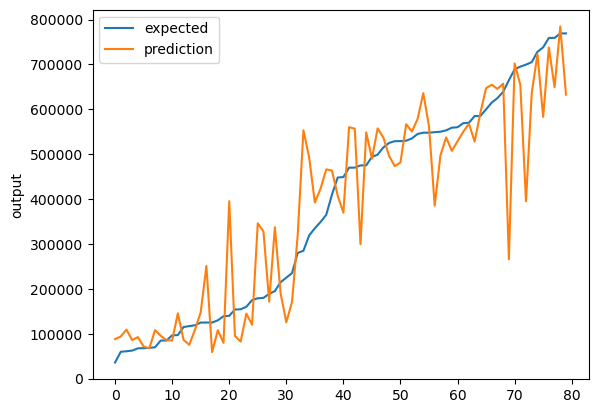

In [59]:
chart_regression(predictions_add.flatten(),y_test_add, sort= True)

In [60]:
end = time.time()
elapsed = end - start
print(hms_string(elapsed))

0:03:34.10
